In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# HYPOTHESIS: Capital flows between Tech (QQQ) and Gold (GLD) based on risk sentiment.
# We download 4 years of data to capture various market regimes.
tickers = ['QQQ', 'GLD']
raw_data = yf.download(tickers, start='2020-01-01', end='2024-01-01')

data = raw_data['Close'].copy()

# Data Cleaning: Forward filling missing values to prevent signal distortion
data.fillna(method='ffill', inplace=True)
data.dropna(inplace=True)

data.head()

/tmp/ipython-input-3734570973.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, start='2020-01-01', end='2024-01-01')
[*********************100%***********************]  2 of 2 completed
/tmp/ipython-input-3734570973.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


Ticker,GLD,QQQ
Date,,
2020-01-02,143.949997,208.580200
2020-01-03,145.860001,206.669601
2020-01-06,147.389999,208.001282
2020-01-07,147.970001,207.972305
2020-01-08,146.860001,209.535492


In [12]:
# 1. Weighted Moving Average (WMA): More responsive to recent volatility
def weighted_moving_average(prices, period):
    weights = np.arange(1, period + 1)
    return prices.rolling(period).apply(lambda p: np.dot(p, weights) / weights.sum(), raw=True)

data['QQQ_WMA20'] = weighted_moving_average(data['QQQ'], 20)
data['GLD_WMA20'] = weighted_moving_average(data['GLD'], 20)

# 2. Relative Strength Index (RSI): Identifying overbought exhaustion
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['QQQ_RSI14'] = calculate_rsi(data['QQQ'], 14)

# 3. Bollinger Bands: Measuring volatility extremes for mean reversion
data['BB_Mean'] = data['QQQ'].rolling(window=20).mean()
data['BB_Std'] = data['QQQ'].rolling(window=20).std()
data['Upper_Band'] = data['BB_Mean'] + (data['BB_Std'] * 2)

In [13]:
# Initialize Signal (0 = Cash, 1 = Long QQQ)
data['Signal'] = 0

# BUY LOGIC: QQQ is trending, Gold is weak (Risk-On), and Tech isn't overbought
buy_condition = (data['QQQ'] > data['QQQ_WMA20']) & \
                (data['GLD'] < data['GLD_WMA20']) & \
                (data['QQQ_RSI14'] < 70)

data.loc[buy_condition, 'Signal'] = 1

# EXIT LOGIC: Exit if Tech breaks trend OR hits extreme Bollinger/RSI levels
exit_condition = (data['QQQ'] < data['QQQ_WMA20']) | \
                 (data['QQQ_RSI14'] > 80) | \
                 (data['QQQ'] > data['Upper_Band'])

data.loc[exit_condition, 'Signal'] = 0

# Smoothing: Maintain position until a hard exit is triggered
data['Signal'] = data['Signal'].replace(0, np.nan).ffill().fillna(0)

In [14]:
# Benchmark Returns vs Strategy Returns (Shifted for execution lag)
data['QQQ_Returns'] = data['QQQ'].pct_change()
data['Strategy_Returns'] = data['Signal'].shift(1) * data['QQQ_Returns']

# Cumulative Growth
data['Strategy_Cum'] = (1 + data['Strategy_Returns'].fillna(0)).cumprod()
data['Bench_Cum'] = (1 + data['QQQ_Returns'].fillna(0)).cumprod()

# --- Performance Metrics ---
# 1. Sharpe Ratio: Risk-adjusted return
risk_free_rate = 0.02 / 252
excess_returns = data['Strategy_Returns'].dropna() - risk_free_rate
sharpe_ratio = np.sqrt(252) * (excess_returns.mean() / excess_returns.std())

# 2. Maximum Drawdown: Assessing worst-case loss
rolling_max = data['Strategy_Cum'].cummax()
drawdown = data['Strategy_Cum'] / rolling_max - 1
max_drawdown = drawdown.min()

# 3. Alpha: Performance relative to the market benchmark
alpha = (data['Strategy_Cum'].iloc[-1] - 1) - (data['Bench_Cum'].iloc[-1] - 1)

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Alpha: {alpha:.2%}")

Sharpe Ratio: 0.61
Max Drawdown: -35.12%
Alpha: -13.27%


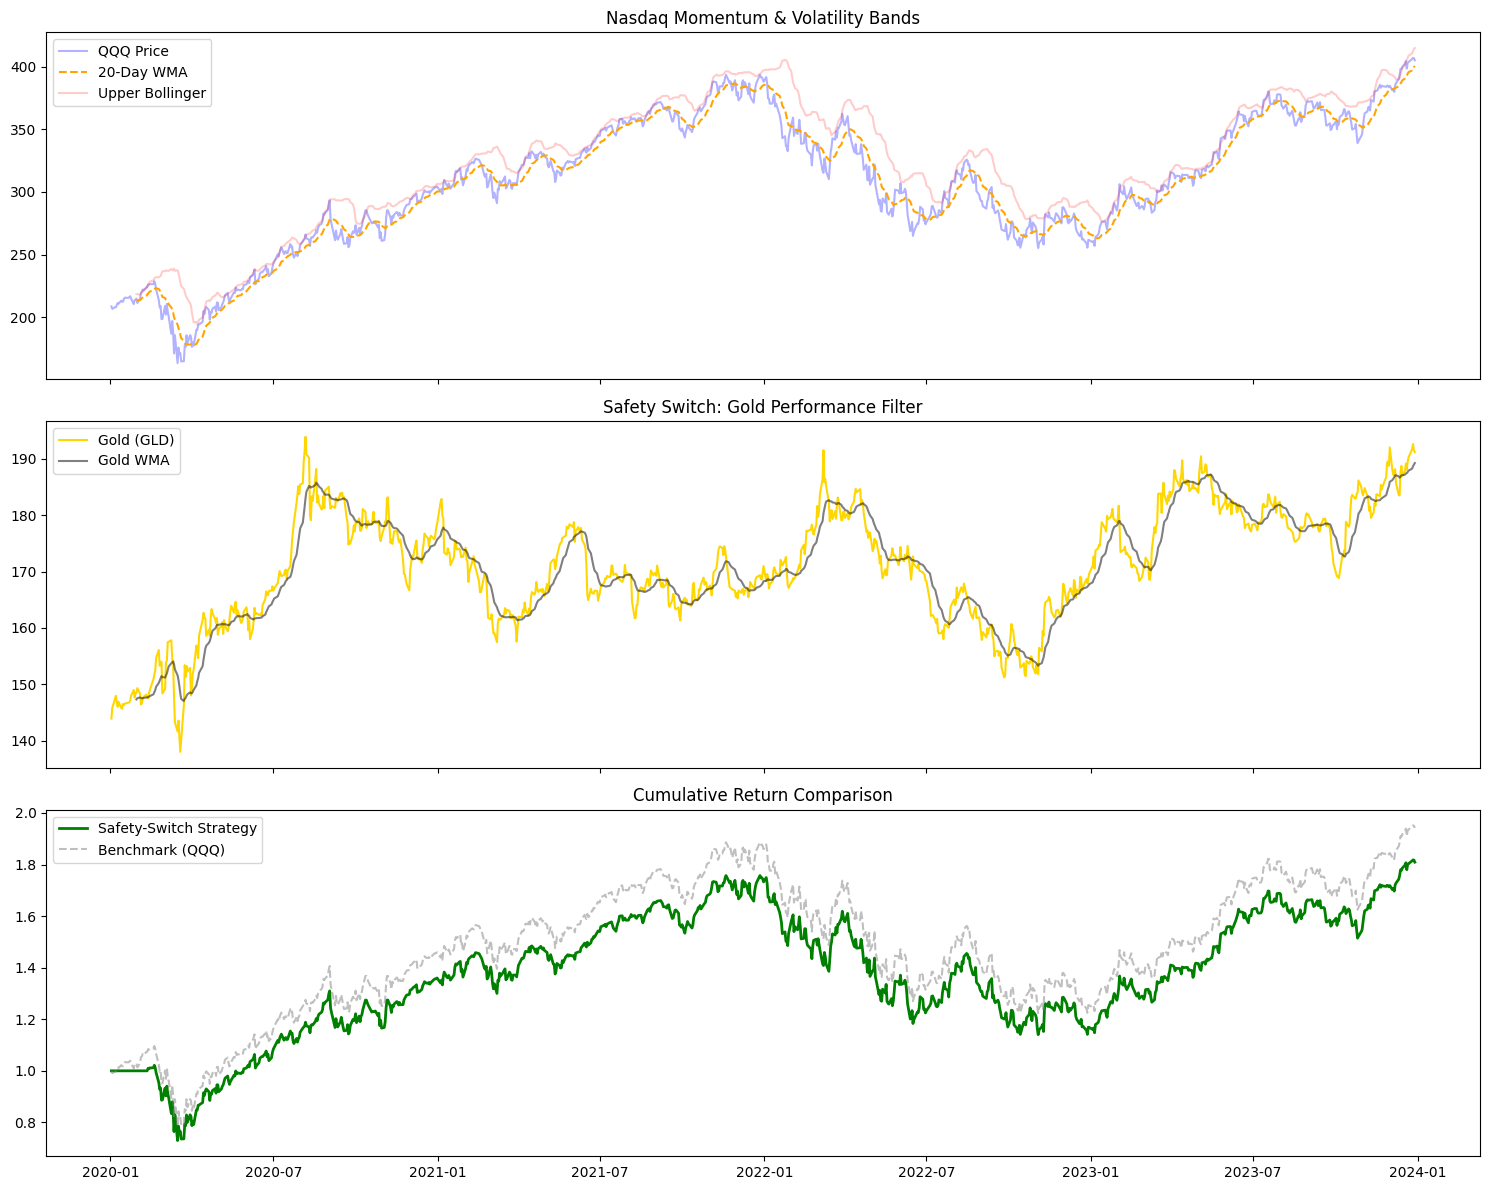

In [15]:
# 3-Panel Dashboard for the presentation slides
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Panel 1: Tech Trend & Bollinger Bands
ax1.plot(data['QQQ'], label='QQQ Price', color='blue', alpha=0.3)
ax1.plot(data['QQQ_WMA20'], label='20-Day WMA', color='orange', linestyle='--')
ax1.plot(data['Upper_Band'], label='Upper Bollinger', color='red', alpha=0.2)
ax1.set_title('Nasdaq Momentum & Volatility Bands')
ax1.legend()

# Panel 2: The Safety Switch (Gold)
ax2.plot(data['GLD'], label='Gold (GLD)', color='gold')
ax2.plot(data['GLD_WMA20'], label='Gold WMA', color='black', alpha=0.5)
ax2.set_title('Safety Switch: Gold Performance Filter')
ax2.legend()

# Panel 3: Strategy Equity Curve
ax3.plot(data['Strategy_Cum'], label='Safety-Switch Strategy', color='green', linewidth=2)
ax3.plot(data['Bench_Cum'], label='Benchmark (QQQ)', color='gray', linestyle='--', alpha=0.5)
ax3.set_title('Cumulative Return Comparison')
ax3.legend()

plt.tight_layout()
plt.show()

In [16]:
final_stats = {
    "Strategy Final Value": data['Strategy_Cum'].iloc[-1],
    "Benchmark Final Value": data['Bench_Cum'].iloc[-1],
    "Risk Adjusted Return (Sharpe)": sharpe_ratio
}

for key, value in final_stats.items():
    print(f"{key}: {value:.4f}")


Strategy Final Value: 1.8093
Benchmark Final Value: 1.9419
Risk Adjusted Return (Sharpe): 0.6106
